# Choroid Plexus and CSF

## Set Up

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process

import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, HTML, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace


#### Reload modules

In [ ]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

# import utils
from utils import zscore
from my_namespace import presentation_cols, colors
# from my_namespace import *

# import regression_utils as regutils

#### Load Data

##### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/3-CP_CSF_analysis"
)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")


MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

#### Functions

In [68]:
def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = regutils.residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["posterior", "medial", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"THALAMUS_1 vs {struct}"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"THALAMUS_1 vs {struct}"] >= 0.05:
            sign = "="
        elif abs(pearson_results["THALAMUS_1"][0]) > abs(pearson_results[struct][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps


def plot_compartment_betas(plot_data):
    # Create evenly spaced x values
    x = np.arange(len(plot_data))  # [0, 1, 2, 3, 4]

    # Calculate errors
    y_lower = plot_data["coef"] - plot_data["llci"]
    y_upper = plot_data["ulci"] - plot_data["coef"]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the points and error bars
    # ? ax.plot(x, plot_data['coef'], '-o',
    # ?         color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)
    ax.scatter(x, plot_data["coef"])
    ax.errorbar(
        x,
        plot_data["coef"],
        yerr=[y_lower, y_upper],
        fmt="o",
        markersize=10,
        color=colors["grey3"],
        ecolor=colors["grey4"],
        capsize=6,
        capthick=2.5,
        linewidth=2.5,
        markeredgewidth=2,
        markeredgecolor="white",
    )

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(
        [
            "lateral\nventricles",
            "interthalamic\nCSF",
            "third\nventricle",
            "fourth\nventricle",
            "subarachnoid\nCSF",
        ]
    )
    ax.set_xlabel("Compartment", fontsize=12, fontweight="bold", labelpad=10)
    ax.set_ylabel("ρ (partial correlation)", fontsize=12, fontweight="bold", labelpad=10)
    ax.set_title(
        "Partial correlations between CP and CSF Compartments",
        fontsize=13,
        fontweight="bold",
        pad=20,
    )

## Analysis around CP

Peripheral CSF segmentation was obtained starting from the `FAST` CSF segmentation, then subtracting the lateral, third, and fourth ventricles and also label 24 from Freesurfer's `aseg.auto_noCCseg` segmentation (technically Fastsurfer's)

### Does CP drive central atrophy?

Previous analysis showed that CP is very strongly associated with LV; in fact, of all the variables I'm looking at, LV is the one with the strongest association with CP. Both CP and LV enlarge in MS. We know that LV enlargement can be indicative of a few different pathologic processes.

1. Overproduction of CSF
2. Atrophy
3. CSF obstruction

Also, atrophy associated with ventricular enlargement could be global or central. 

#### Relationship between CP and CSF compartment volumes

**Does CP predict the volume of the third ventricle, fourth ventricle, and peripheral CSF, and which ones is it most strongly associated with?**

- CP has the strongest relationship with the LV's, then aseg label 24\*, then the third ventricle, and finally the fourth ventricle. 

\**Freesurfer's aseg segmentation has a label 24 called "CSF" which is a misnomer because it is actually pretty small and located at some periaqueductal/interthalamic CSF pocket.*

- Call it interthalamic CSF

In [69]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])

outcomes = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "PRL"]
covariates = ["age", "Female", "tiv"]

_, results, check = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

# for predictor, result in results.items():
for predictor in ["CP", "t2lv_log"]:
    result = results[predictor]
    formula = regutils.formula_string("outcome", predictor, covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
outcome ~ CP + age + Female + tiv
```


| outcome      |   coef |    pval |   p_fdr |     se | ci              |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:----------------|-----:|
| LV_log       | 0.6457 | 4.4e-85 | 2.2e-84 | 0.033  | [0.581, 0.71]   | 0.57 |
| interCSF_log | 0.4676 | 7.3e-26 | 1.8e-25 | 0.0445 | [0.38, 0.555]   | 0.27 |
| thirdV_log   | 0.4264 | 7.5e-24 | 1.3e-23 | 0.0424 | [0.343, 0.509]  | 0.35 |
| fourthV_log  | 0.23   | 4.8e-06 | 6e-06   | 0.0503 | [0.131, 0.329]  | 0.14 |
| periCSF_log  | 0.1523 | 1.7e-05 | 1.7e-05 | 0.0354 | [0.0828, 0.222] | 0.57 |

```R
outcome ~ t2lv_log + age + Female + tiv
```


| outcome      |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| LV_log       | 0.3992 | 2.5e-13 | 1.3e-12 | 0.0545 | [0.292, 0.506]   | 0.38 |
| thirdV_log   | 0.3312 | 7.5e-09 | 1.9e-08 | 0.0573 | [0.219, 0.443]   | 0.31 |
| interCSF_log | 0.2797 | 1.3e-05 | 2.2e-05 | 0.0642 | [0.154, 0.406]   | 0.17 |
| fourthV_log  | 0.1539 | 0.0024  | 0.003   | 0.0507 | [0.0544, 0.253]  | 0.12 |
| periCSF_log  | 0.0407 | 0.28    | 0.28    | 0.0377 | [-0.0332, 0.115] | 0.55 |

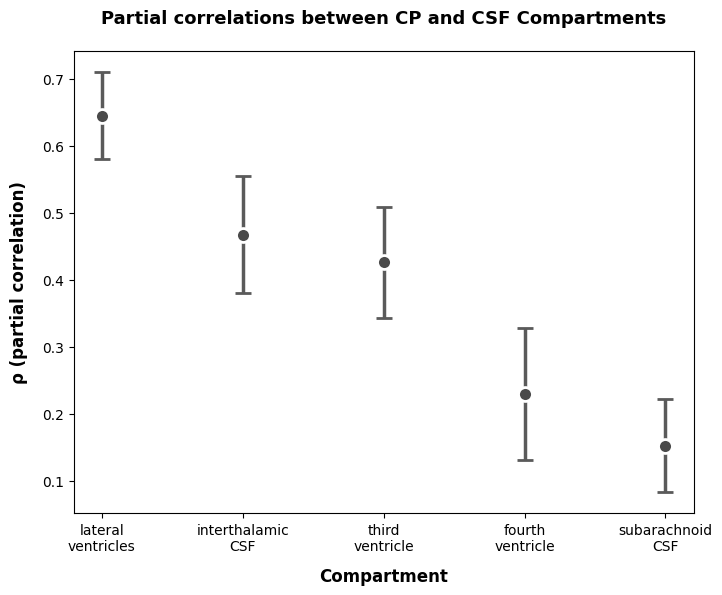

In [72]:
plot_compartment_betas(results['CP'])

In [73]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "add CP and t2lv": ["CP", "t2lv_log", "age", "Female", "tiv"],
}
results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_regressions(
        model_data, outcome, predictors, covariates=covariates, regression_model="GLM"
    )


for name, result in results.items():
    covariates = test_covariates[name]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
PRL ~ *predictor* + age + Female + tiv
```


| predictor    |   coef |    pval |   p_fdr |     se | ci             |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:---------------|-----:|
| periCSF_log  | 0.5146 | 0.00013 | 0.00017 | 0.1348 | [0.25, 0.779]  | 0.29 |
| thirdV_log   | 0.4192 | 7.8e-07 | 2.8e-06 | 0.0848 | [0.253, 0.585] | 0.31 |
| LV_log       | 0.4066 | 1.1e-06 | 2.8e-06 | 0.0835 | [0.243, 0.57]  | 0.3  |
| interCSF_log | 0.3253 | 2.2e-05 | 3.7e-05 | 0.0767 | [0.175, 0.476] | 0.28 |
| fourthV_log  | 0.2977 | 0.00037 | 0.00037 | 0.0836 | [0.134, 0.462] | 0.28 |

```R
PRL ~ *predictor* + CP + t2lv_log + age + Female + tiv
```


| predictor    |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| periCSF_log  | 0.3954 | 0.00097 |  0.0048 | 0.1198 | [0.16, 0.63]     | 0.42 |
| fourthV_log  | 0.1782 | 0.034   |  0.084  | 0.0839 | [0.0138, 0.343]  | 0.39 |
| thirdV_log   | 0.1651 | 0.088   |  0.13   | 0.0969 | [-0.0248, 0.355] | 0.39 |
| interCSF_log | 0.1337 | 0.1     |  0.13   | 0.0814 | [-0.0258, 0.293] | 0.39 |
| LV_log       | 0.0522 | 0.66    |  0.66   | 0.1204 | [-0.184, 0.288]  | 0.38 |

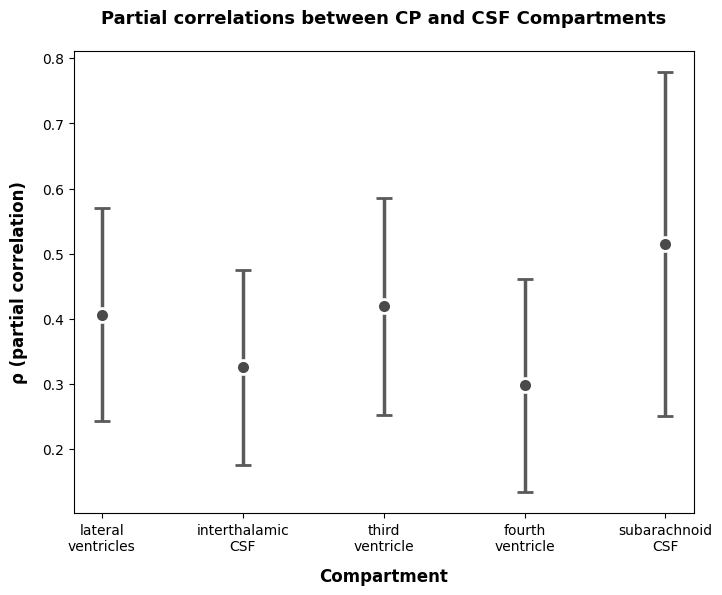

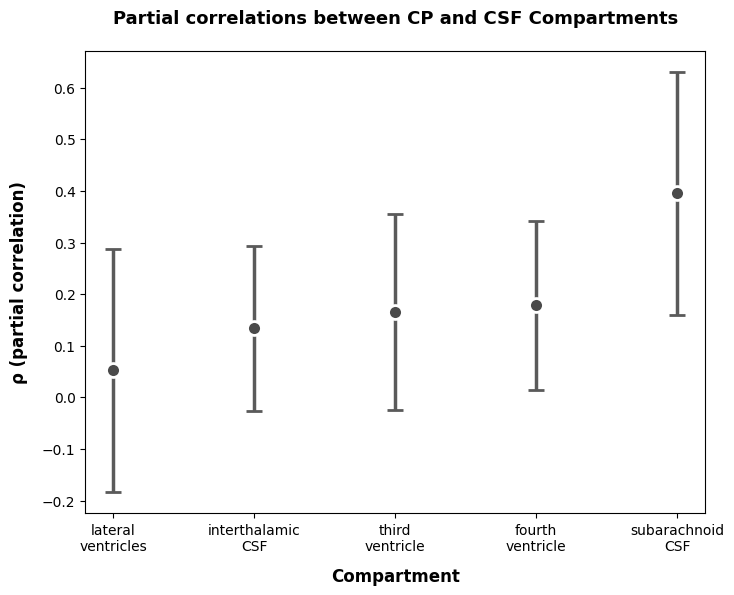

In [74]:
result = results['basic']
plot_compartment_betas(result)

result = results['add CP and t2lv']
plot_compartment_betas(result)

CP predicts these compartment volumes after controlling for brain and thalamus, but t2lv does not

In [65]:
covariates = ["THALAMUS_1", "brain", "age", "Female", "tiv"]
outcomes = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]

predictors = ["CP", "t2lv_log"]
_, results, _ = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

# predictor_to_show = "CP"
# formula = regutils.formula_string("outcome", predictor_to_show, covariates)
# results_present = results[predictor_to_show].rename(
#     index={
#         # "interCSF_log": "aseg24_CSF_log",
#         # "thirdV_log": "aseg14_thirdV",
#         # "fourthV_log": "aseg15_fourthV",
#     }
# )

for predictor in ["CP", "t2lv_log"]:
    result = results[predictor]
    display(
        Markdown(
            f"**Effect of {predictor} on outcomes after accounting for brain and THALAMUS_1 as well**"
        )
    )
    formula = regutils.formula_string("outcome", predictor, covariates)
    display(Markdown(f"`{formula}`"))
    display(
        Markdown(regutils.present_model(result, presentation_cols).to_markdown())
    )

**Effect of CP on outcomes after accounting for brain and THALAMUS_1 as well**

`outcome ~ CP + THALAMUS_1 + brain + age + Female + tiv`

| outcome      |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| LV_log       | 0.4816 | 3.3e-40 | 1.6e-39 | 0.0363 | [0.411, 0.553]   | 0.67 |
| interCSF_log | 0.2857 | 1.4e-09 | 3.5e-09 | 0.0472 | [0.193, 0.378]   | 0.37 |
| thirdV_log   | 0.2205 | 1.1e-07 | 1.8e-07 | 0.0415 | [0.139, 0.302]   | 0.48 |
| fourthV_log  | 0.1328 | 0.019   | 0.024   | 0.0568 | [0.0214, 0.244]  | 0.17 |
| periCSF_log  | 0.0528 | 0.15    | 0.15    | 0.0366 | [-0.0188, 0.125] | 0.61 |

**Effect of t2lv_log on outcomes after accounting for brain and THALAMUS_1 as well**

`outcome ~ t2lv_log + THALAMUS_1 + brain + age + Female + tiv`

| outcome      |    coef |   pval |   p_fdr |     se | ci               |   R2 |
|:-------------|--------:|-------:|--------:|-------:|:-----------------|-----:|
| LV_log       |  0.1442 | 0.0078 |   0.039 | 0.0542 | [0.038, 0.25]    | 0.54 |
| interCSF_log |  0.0336 | 0.57   |   0.57  | 0.0592 | [-0.0825, 0.15]  | 0.32 |
| thirdV_log   |  0.0874 | 0.11   |   0.28  | 0.0552 | [-0.0207, 0.196] | 0.46 |
| fourthV_log  |  0.0549 | 0.33   |   0.41  | 0.0565 | [-0.0559, 0.166] | 0.16 |
| periCSF_log  | -0.0494 | 0.24   |   0.4   | 0.0421 | [-0.132, 0.0332] | 0.61 |

#### Sanity check on peripheral CSF

The following is more of a sanity check. If all the CSF volumes are defined properly, particulary peripheral CSF, we'd expect thalamic volume to be related more to the central CSF compartments and for brain volume to be related more to the peripheral CSF volume. This is borne out. Peripheral CSF has a much stronger relationship to WBV and LV has a much stronger relationship to thalamus

In [ ]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

rename_index = {"brain": "**brain**", "THALAMUS_1": "**THALAMUS_1**"}

test_outcomes = ["LV_log", "thirdV_log", "fourthV_log", "periCSF"]
all_results = defaultdict(dict)
all_models = defaultdict(dict)
all_formulas = defaultdict(dict)
for outcome in test_outcomes:
    formula_list = {
        "brain": f"{outcome} ~ brain + age + Female + tiv",
        "thalamus": f"{outcome} ~ THALAMUS_1 + age + Female + tiv",
        "brain+thalamus": f"{outcome} ~ brain + THALAMUS_1 + age + Female + tiv",
    }

    all_results[outcome], all_models[outcome], all_formulas[outcome] = (
        regutils.run_regressions3(
            model_data_z, formula_list.values(), model_names=formula_list.keys()
        )
    )

outcome = "periCSF"
display(Markdown(f"##### {outcome}"))
results = all_results[outcome]
formulas = all_formulas[outcome]

# model_name = "thalamus"
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols,
#                                         rename_index=rename_index).to_markdown()))
# display(Markdown("---"))

model_name = "brain+thalamus"
model = results[model_name]
formula = formulas[model_name]

display(Markdown(f"{model_name}"))
display(Markdown(f"`{formula}`"))
display(
    Markdown(
        regutils.present_model(
            model, presentation_cols, rename_index=rename_index
        ).to_markdown()
        + "\n\n"
    )
)
# display(Markdown("---"))


outcome = "LV_log"
display(Markdown(f"##### {outcome}"))
results = all_results[outcome]
formulas = all_formulas[outcome]

# model_name = "brain"
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols,
#                                         rename_index=rename_index).to_markdown()))
# display(Markdown("---"))

model_name = "brain+thalamus"
model = results[model_name]
formula = formulas[model_name]

display(Markdown(f"{model_name}"))
display(Markdown(f"`{formula}`"))
display(
    Markdown(
        regutils.present_model(
            model, presentation_cols, rename_index=rename_index
        ).to_markdown()
    )
)
display(
    Markdown(
        "*Note: brain has a significant association with LV_log before controlling for THALAMUS_1*"
    )
)
# display(Markdown("---"))

##### periCSF

brain+thalamus

`periCSF ~ brain + THALAMUS_1 + age + Female + tiv`

|                |    coef |     pval |     se | ci                 |   R2 |
|:---------------|--------:|---------:|-------:|:-------------------|-----:|
| Intercept      | -0.1526 | 0.04     | 0.0744 | [-0.298, -0.00681] | 0.62 |
| Female[T.1]    |  0.1985 | 0.02     | 0.085  | [0.0319, 0.365]    | 0.62 |
| **brain**      | -0.2327 | 7.2e-11  | 0.0357 | [-0.303, -0.163]   | 0.62 |
| **THALAMUS_1** | -0.1109 | 0.013    | 0.0445 | [-0.198, -0.0237]  | 0.62 |
| age            |  0.0609 | 0.074    | 0.0341 | [-0.00597, 0.128]  | 0.62 |
| tiv            |  0.8337 | 4.1e-109 | 0.0376 | [0.76, 0.907]      | 0.62 |



##### LV_log

brain+thalamus

`LV_log ~ brain + THALAMUS_1 + age + Female + tiv`

|                |    coef |    pval |     se | ci                |   R2 |
|:---------------|--------:|--------:|-------:|:------------------|-----:|
| Intercept      | -0.0549 | 0.46    | 0.0743 | [-0.201, 0.0908]  | 0.52 |
| Female[T.1]    |  0.073  | 0.42    | 0.0901 | [-0.104, 0.25]    | 0.52 |
| **brain**      | -0.0151 | 0.72    | 0.0426 | [-0.0987, 0.0685] | 0.52 |
| **THALAMUS_1** | -0.6317 | 8.7e-59 | 0.0391 | [-0.708, -0.555]  | 0.52 |
| age            |  0.2105 | 1.3e-09 | 0.0347 | [0.142, 0.279]    | 0.52 |
| tiv            |  0.4906 | 2.2e-29 | 0.0436 | [0.405, 0.576]    | 0.52 |

*Note: brain has a significant association with LV_log before controlling for THALAMUS_1*

### CP drives preferential central expansion

Does the relationship between CP and LV volumes represent a global process whereby CP influences overall atrophy or CSF hydrodynamics, or is CP causing regional changes? With the degree of preferential central expansion defined as the central CSF ratio (CCR):

$CCR = LV / periCSF$

**CP is associated with increasing CCR, beyond what is predicted by brain or thalamus volumes.**

In [ ]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

test_outcomes = ["CCR_log"]
predictors = ["CP"]
covariates = ["THALAMUS_1", "age", "Female", "tiv"]

_, results, formulas = regutils.run_regressions(
    model_data_z, test_outcomes, predictors, covariates=covariates
)

predictor_to_show = "CP"
formula = regutils.formula_string("outcome", predictor_to_show, covariates)
# display(Markdown(f"`{formula}`"))
display(Markdown(f"```R\n{results[predictor_to_show].formula[0]}\n```"))
display(
    Markdown(
        regutils.present_model(
            results[predictor_to_show], presentation_cols
        ).to_markdown()
    )
)


test_outcomes = ["CCR_log"]
predictors = ["CP"]
covariates = ["brain", "age", "Female", "tiv"]

_, results, formulas = regutils.run_regressions(
    model_data_z, test_outcomes, predictors, covariates=covariates
)

predictor_to_show = "CP"
formula = regutils.formula_string("outcome", predictor_to_show, covariates)
display(Markdown(f"```R\n{results[predictor_to_show].formula[0]}\n```\n"))
display(
    Markdown(
        regutils.present_model(
            results[predictor_to_show], presentation_cols
        ).to_markdown()
    )
)


```R
CCR_log ~ CP + THALAMUS_1 + age + Female + tiv
```

| outcome   |   coef |    pval |   p_fdr |     se | ci             |   R2 |
|:----------|-------:|--------:|--------:|-------:|:---------------|-----:|
| CCR_log   | 0.4713 | 8.2e-31 | 8.2e-31 | 0.0379 | [0.397, 0.546] | 0.61 |

```R
CCR_log ~ CP + brain + age + Female + tiv
```


| outcome   |   coef |    pval |   p_fdr |     se | ci             |   R2 |
|:----------|-------:|--------:|--------:|-------:|:---------------|-----:|
| CCR_log   |  0.635 | 6.7e-48 | 6.7e-48 | 0.0387 | [0.559, 0.711] | 0.51 |

Alternative presentation for the above

CT has inverse association with CCR, indicating that atrophy occurs quicker centrally than peripherally in general

In [ ]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

outcome = "CCR2_log"

exog_list = {
    "CP alone": ["CP"],
    "CP, control for brain": ["CP", "brain"],
    "CP, control for thalamus": ["CP", "THALAMUS_1"],
    "t2lv, control for thalamus": ["t2lv_log", "THALAMUS_1"],
    "CP and t2lv": ["CP", "t2lv_log"],
    "CP t2lv and thalamus": ["CP", "t2lv_log", "THALAMUS_1"],
    "CP brain and t2lv": ["CP", "brain", "t2lv_log"],
    "Just brain": ["brain"],
    "Just thalamus": ["THALAMUS_1"],
    #! Remember to think about this: it gave important insight about CCR
    "Just CT": ["cortical_thickness"],
    "t2lv and brain": ["t2lv_log", "brain"],
    "t2lv and thalamus": ["t2lv_log", "THALAMUS_1"],
}
covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    exog_list.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    # display(Markdown(f"`{formula}`"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                model,
                presentation_cols,
                exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
            ).to_markdown()
        )
    )
    display(Markdown("---"))

# _, results = regutils.run_regressions(
#     model_data_z, test_outcomes, predictors, covariates=covariates
# )

# predictor_to_show = "CP"
# formula = regutils.formula_string("outcome", predictor_to_show, covariates)
# display(Markdown(f"**Effect of {predictor_to_show} on outcome**"))
# display(Markdown(f"`{formula}`"))

# results[predictor_to_show]

#### CP alone

```R
CCR2_log ~ CP + age + Female + tiv
```


|    |   coef |    pval |     se | ci             |
|:---|-------:|--------:|-------:|:---------------|
| CP | 0.6355 | 1.3e-56 | 0.0347 | [0.567, 0.704] |

---

#### CP, control for brain

```R
CCR2_log ~ CP + brain + age + Female + tiv
```


|       |   coef |    pval |     se | ci               |
|:------|-------:|--------:|-------:|:-----------------|
| CP    |  0.629 | 3.7e-47 | 0.0388 | [0.553, 0.705]   |
| brain | -0.022 | 0.59    | 0.0408 | [-0.102, 0.0583] |

---

#### CP, control for thalamus

```R
CCR2_log ~ CP + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| CP         |  0.4635 | 4.1e-30 | 0.0378 | [0.389, 0.538]   |
| THALAMUS_1 | -0.4109 | 2.1e-20 | 0.0423 | [-0.494, -0.328] |

---

#### t2lv, control for thalamus

```R
CCR2_log ~ t2lv_log + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| t2lv_log   |  0.1557 | 0.0084  | 0.0588 | [0.0401, 0.271]  |
| THALAMUS_1 | -0.5366 | 1.5e-24 | 0.0495 | [-0.634, -0.439] |

---

#### CP and t2lv

```R
CCR2_log ~ CP + t2lv_log + age + Female + tiv
```


|          |   coef |    pval |     se | ci             |
|:---------|-------:|--------:|-------:|:---------------|
| CP       | 0.5535 | 3.4e-37 | 0.0397 | [0.476, 0.631] |
| t2lv_log | 0.2377 | 1.2e-06 | 0.0482 | [0.143, 0.332] |

---

#### CP t2lv and thalamus

```R
CCR2_log ~ CP + t2lv_log + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| CP         |  0.4512 | 2.4e-28 | 0.0382 | [0.376, 0.526]   |
| t2lv_log   |  0.1035 | 0.028   | 0.0471 | [0.0111, 0.196]  |
| THALAMUS_1 | -0.3549 | 2.3e-13 | 0.047  | [-0.447, -0.263] |

---

#### CP brain and t2lv

```R
CCR2_log ~ CP + brain + t2lv_log + age + Female + tiv
```


|          |    coef |    pval |     se | ci               |
|:---------|--------:|--------:|-------:|:-----------------|
| CP       |  0.5504 | 1.7e-33 | 0.042  | [0.468, 0.633]   |
| brain    | -0.0112 | 0.77    | 0.0388 | [-0.0875, 0.065] |
| t2lv_log |  0.2373 | 1.3e-06 | 0.0483 | [0.142, 0.332]   |

---

#### Just brain

```R
CCR2_log ~ brain + age + Female + tiv
```


|       |   coef |    pval |     se | ci               |
|:------|-------:|--------:|-------:|:-----------------|
| brain | -0.216 | 1.1e-05 | 0.0485 | [-0.311, -0.121] |

---

#### Just thalamus

```R
CCR2_log ~ THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| THALAMUS_1 | -0.6295 | 2.6e-51 | 0.0367 | [-0.702, -0.557] |

---

#### Just CT

```R
CCR2_log ~ cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci               |
|:-------------------|--------:|--------:|-------:|:-----------------|
| cortical_thickness | -0.4595 | 4.8e-25 | 0.0419 | [-0.542, -0.377] |

---

#### t2lv and brain

```R
CCR2_log ~ t2lv_log + brain + age + Female + tiv
```


|          |    coef |    pval |     se | ci                |
|:---------|--------:|--------:|-------:|:------------------|
| t2lv_log |  0.3856 | 1.9e-11 | 0.056  | [0.276, 0.496]    |
| brain    | -0.1591 | 0.00084 | 0.0473 | [-0.252, -0.0661] |

---

#### t2lv and thalamus

```R
CCR2_log ~ t2lv_log + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| t2lv_log   |  0.1557 | 0.0084  | 0.0588 | [0.0401, 0.271]  |
| THALAMUS_1 | -0.5366 | 1.5e-24 | 0.0495 | [-0.634, -0.439] |

---

##### CP fully mediates the relationship between brain and CCR.

CP enlargement appeared to account for the relationship between whole brain atrophy and central CSF predominance. While brain volume alone predicted CCF (β*=-0.204, p<0.001), this association became non-significant when CP was included in the model (β*=-0.020, p=0.63), suggesting CP-associated processes mediate the central component of brain atrophy. This contrasts with T2 lesion volume, which showed independent effects alongside brain volume (both p<0.001), consistent with T2 lesions representing more diffuse pathology.

In [ ]:
p2 = Process(
    data=model_data_z,
    model=4,
    x="brain",
    y="CCR2_log",
    m=["CP"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
    suppr_init=True,
)

outcome, mediation = utils.read_pyprocess_output(p2)

print("=" * 80)
print(mediation)
print("=" * 80)



Direct effect of brain on CCR2_log:

  Effect     SE       t      p    LLCI   ULCI
 -0.0220 0.0391 -0.5620 0.5744 -0.0986 0.0547

Indirect effect of brain on CCR2_log:

      Effect  Boot SE  BootLLCI  BootULCI
  CP -0.1940   0.0323   -0.2589   -0.1338




In [ ]:
p2 = Process(
    data=model_data_z,
    model=4,
    x="t2lv_log",
    y="CCR2_log",
    m=["brain"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
    suppr_init=True,
)

outcome, mediation = utils.read_pyprocess_output(p2)

print("=" * 80)
print(mediation)
print("=" * 80)



Direct effect of t2lv_log on CCR2_log:

  Effect     SE      t      p   LLCI   ULCI
  0.3856 0.0395 9.7550 0.0000 0.3081 0.4631

Indirect effect of t2lv_log on CCR2_log:

         Effect  Boot SE  BootLLCI  BootULCI
  brain  0.0197   0.0092    0.0059    0.0434




### Scratchpad

In [20]:
work_data = zscore(data[MS_patients].copy())
csf_vars = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
all_vars = csf_vars + predictors
resid_data = work_data[all_vars].copy()
covariates = ["age", "Female", "tiv"]

for var in all_vars:
    resid_data[var] = utils.residualize_structs(work_data, var, covariates)

# resid_data = resid_data.dropna()
resid_data_z = zscore(resid_data)

In [66]:
model_data = resid_data

csf_compartments = [
    "LV_log",
    "interCSF_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF_log",
]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
covariates = None

_, results, check = regutils.run_regressions(
    model_data, csf_compartments, predictors, covariates=covariates
)

Text(0.5, 1.0, 'Partial correlations between CP and CSF Compartments')

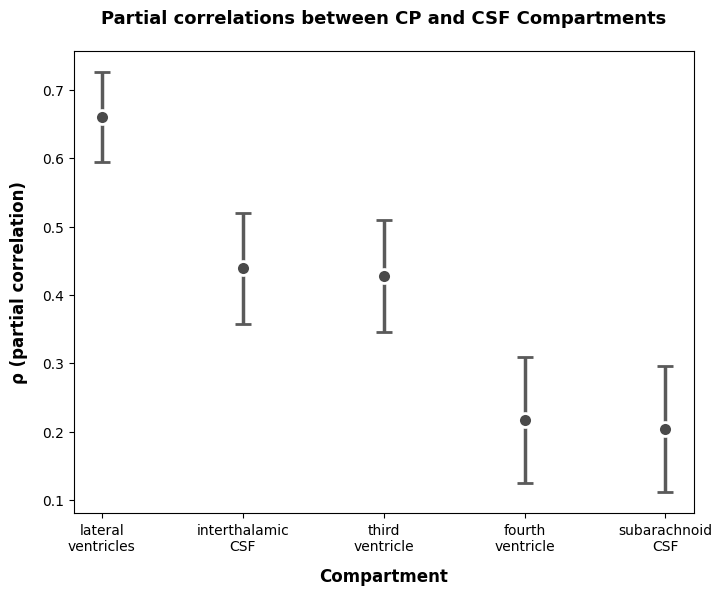

In [ ]:
plot_data = results["CP"]

# Create evenly spaced x values
x = np.arange(len(csf_compartments))  # [0, 1, 2, 3, 4]

# Calculate errors
y_lower = plot_data["coef"] - plot_data["llci"]
y_upper = plot_data["ulci"] - plot_data["coef"]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the points and error bars
# ? ax.plot(x, plot_data['coef'], '-o',
# ?         color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)
ax.scatter(x, plot_data["coef"])
ax.errorbar(
    x,
    plot_data["coef"],
    yerr=[y_lower, y_upper],
    fmt="o",
    markersize=10,
    color=colors["grey3"],
    ecolor=colors["grey4"],
    capsize=6,
    capthick=2.5,
    linewidth=2.5,
    markeredgewidth=2,
    markeredgecolor="white",
)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(
    [
        "lateral\nventricles",
        "interthalamic\nCSF",
        "third\nventricle",
        "fourth\nventricle",
        "subarachnoid\nCSF",
    ]
)
ax.set_xlabel("Compartment", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylabel("ρ (partial correlation)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_title(
    "Partial correlations between CP and CSF Compartments",
    fontsize=13,
    fontweight="bold",
    pad=20,
)

In [67]:
results['CP']

,coef,pval,p_fdr,se,llci,ulci,ci,R2,formula,coef_sig
outcome,,,,,,,,,,
LV_log,0.645650,1.626518e-86,8.132590e-86,0.032750,0.581461,0.709840,"[0.581, 0.71]",0.434877,LV_log ~ CP,NaN
interCSF_log,0.467636,3.471464e-26,8.678659e-26,0.044176,0.381052,0.554220,"[0.381, 0.554]",0.190780,interCSF_log ~ CP,NaN
thirdV_log,0.426439,3.538683e-24,5.897805e-24,0.042040,0.344042,0.508836,"[0.344, 0.509]",0.181116,thirdV_log ~ CP,NaN
fourthV_log,0.230004,4.069984e-06,5.087480e-06,0.049916,0.132169,0.327839,"[0.132, 0.328]",0.044782,fourthV_log ~ CP,NaN
periCSF_log,0.152294,1.515735e-05,1.515735e-05,0.035201,0.083301,0.221287,"[0.0833, 0.221]",0.039317,periCSF_log ~ CP,NaN


Text(0.5, 1.0, 'Partial correlations between CP and CSF Compartments')

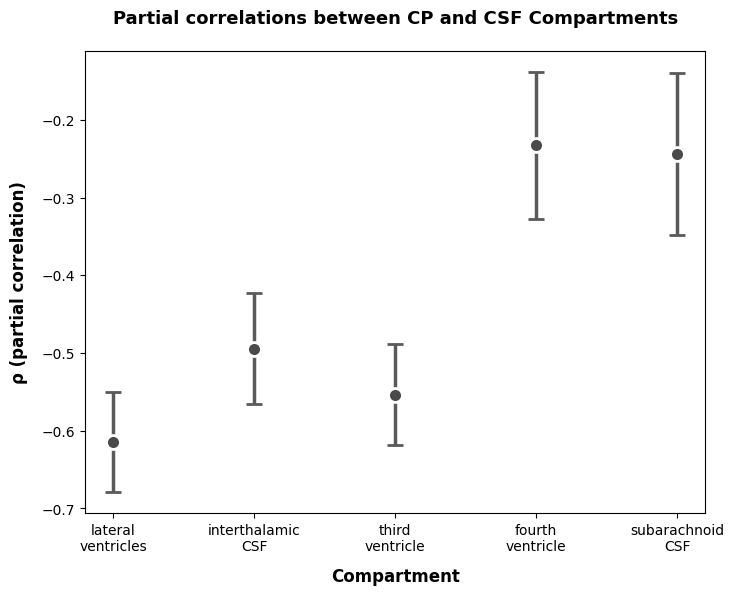

In [ ]:
plot_data = results["THALAMUS_1"]

# Create evenly spaced x values
x = np.arange(len(csf_compartments))  # [0, 1, 2, 3, 4]

# Calculate errors
y_lower = plot_data["coef"] - plot_data["llci"]
y_upper = plot_data["ulci"] - plot_data["coef"]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the points and error bars
# ? ax.plot(x, plot_data['coef'], '-o',
# ?         color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)
ax.scatter(x, plot_data["coef"])
ax.errorbar(
    x,
    plot_data["coef"],
    yerr=[y_lower, y_upper],
    fmt="o",
    markersize=10,
    color=colors["grey3"],
    ecolor=colors["grey4"],
    capsize=6,
    capthick=2.5,
    linewidth=2.5,
    markeredgewidth=2,
    markeredgecolor="white",
)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(
    [
        "lateral\nventricles",
        "interthalamic\nCSF",
        "third\nventricle",
        "fourth\nventricle",
        "subarachnoid\nCSF",
    ]
)
ax.set_xlabel("Compartment", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylabel("ρ (partial correlation)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_title(
    "Partial correlations between CP and CSF Compartments",
    fontsize=13,
    fontweight="bold",
    pad=20,
)

Text(0.5, 1.0, 'Partial correlations between CP and CSF Compartments')

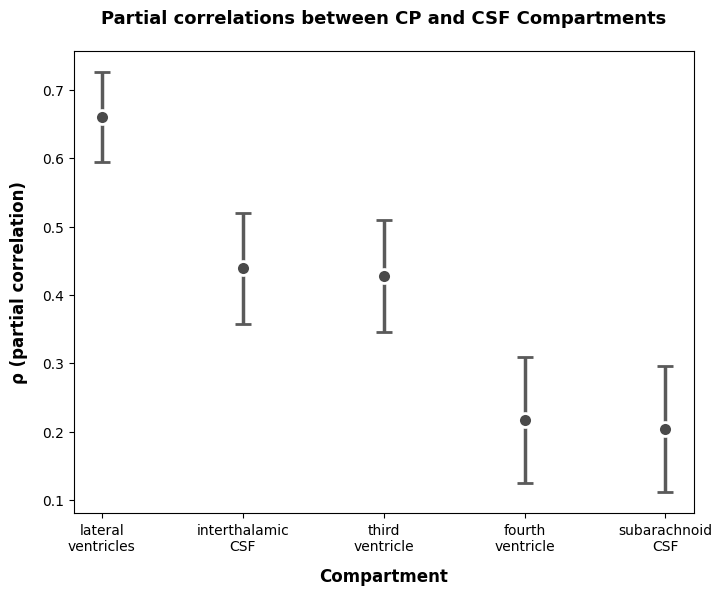

In [ ]:
plot_data = results["CP"]

# Create evenly spaced x values
x = np.arange(len(csf_compartments))  # [0, 1, 2, 3, 4]

# Calculate errors
y_lower = plot_data["coef"] - plot_data["llci"]
y_upper = plot_data["ulci"] - plot_data["coef"]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the points and error bars
# ? ax.plot(x, plot_data['coef'], '-o',
# ?         color='#4A4A4A', linewidth=2, markersize=8, alpha=0.8)
ax.scatter(x, plot_data["coef"])
ax.errorbar(
    x,
    plot_data["coef"],
    yerr=[y_lower, y_upper],
    fmt="o",
    markersize=10,
    color="#4A4A4A",
    ecolor="#5A5A5A",
    capsize=6,
    capthick=2.5,
    linewidth=2.5,
    markeredgewidth=2,
    markeredgecolor="white",
)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(
    [
        "lateral\nventricles",
        "interthalamic\nCSF",
        "third\nventricle",
        "fourth\nventricle",
        "subarachnoid\nCSF",
    ]
)
ax.set_xlabel("Compartment", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylabel("ρ (partial correlation)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_title(
    "Partial correlations between CP and CSF Compartments",
    fontsize=13,
    fontweight="bold",
    pad=20,
)

In [30]:
colors

{'dark red1': '#eb3131',
 'light red1': '#eb7171',
 'dark blue1': '#1f4294',
 'light blue1': '#7a9df0',
 'dark green1': '#2e6023',
 'light green1': '#6dba5c',
 'dark purple1': '#8C1FA7',
 'light purple1': '#BD49DA'}

In [ ]:
plot_data = results["CP"]

x = np.arange(len(csf_compartments))  # [0, 1, 2, 3, 4]
plt.scatter(x, partial_corr_values)
plt.errorbar(x, partial_corr_values, yerr=confidence_intervals, fmt="o", capsize=5)

---

## PRL Analysis

PRL count is predicted most strongly by the peripheral CSF volume. This variable has an even stronger association with PRL than CP and T2LV.

In [ ]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])

model_formulas = {
    "CP,t2lv,LV": "PRL ~ LV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,interCSF": "PRL ~ interCSF_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,thirdV": "PRL ~ thirdV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,fourthV": "PRL ~ fourthV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,periCSF": "PRL ~ periCSF_log + CP + t2lv_log + age + Female + tiv",
    "periCSF": "PRL ~ periCSF_log + age + Female + tiv",
    "CP": "PRL ~ CP + age + Female + tiv",
    "t2lv": "PRL ~ t2lv_log + age + Female + tiv",
}

results, models, formulas = regutils.run_regressions3(
    model_data,
    model_formulas.values(),
    model_names=model_formulas.keys(),
    regression_model="GLM",
    family=sm.families.Poisson(),
)

for formula, result in zip(formulas.values(), results.values()):
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"]
            ).to_markdown()
        )
    )

```R
PRL ~ LV_log + CP + t2lv_log + age + Female + tiv
```


|          |   coef |    pval |     se |       llci |     ulci | ci               |   R2 |
|:---------|-------:|--------:|-------:|-----------:|---------:|:-----------------|-----:|
| LV_log   | 0.0522 | 0.66    | 0.1204 | -0.183813  | 0.288254 | [-0.184, 0.288]  | 0.38 |
| CP       | 0.2674 | 0.072   | 0.1488 | -0.0243428 | 0.559066 | [-0.0243, 0.559] | 0.38 |
| t2lv_log | 0.3096 | 0.00017 | 0.0822 |  0.148536  | 0.470736 | [0.149, 0.471]   | 0.38 |

```R
PRL ~ interCSF_log + CP + t2lv_log + age + Female + tiv
```


|              |   coef |   pval |     se |       llci |     ulci | ci                |   R2 |
|:-------------|-------:|-------:|-------:|-----------:|---------:|:------------------|-----:|
| interCSF_log | 0.1337 | 0.1    | 0.0814 | -0.0258256 | 0.293275 | [-0.0258, 0.293]  | 0.39 |
| CP           | 0.2459 | 0.052  | 0.1264 | -0.001764  | 0.493579 | [-0.00176, 0.494] | 0.39 |
| t2lv_log     | 0.3095 | 0.0001 | 0.0797 |  0.153389  | 0.465665 | [0.153, 0.466]    | 0.39 |

```R
PRL ~ thirdV_log + CP + t2lv_log + age + Female + tiv
```


|            |   coef |    pval |     se |       llci |     ulci | ci               |   R2 |
|:-----------|-------:|--------:|-------:|-----------:|---------:|:-----------------|-----:|
| thirdV_log | 0.1651 | 0.088   | 0.0969 | -0.0248295 | 0.354939 | [-0.0248, 0.355] | 0.39 |
| CP         | 0.2413 | 0.062   | 0.1294 | -0.0122913 | 0.494828 | [-0.0123, 0.495] | 0.39 |
| t2lv_log   | 0.2776 | 0.00069 | 0.0818 |  0.11736   | 0.437927 | [0.117, 0.438]   | 0.39 |

```R
PRL ~ fourthV_log + CP + t2lv_log + age + Female + tiv
```


|             |   coef |    pval |     se |      llci |     ulci | ci              |   R2 |
|:------------|-------:|--------:|-------:|----------:|---------:|:----------------|-----:|
| fourthV_log | 0.1782 | 0.034   | 0.0839 | 0.0137769 | 0.342723 | [0.0138, 0.343] | 0.39 |
| CP          | 0.2644 | 0.023   | 0.1163 | 0.0364139 | 0.492418 | [0.0364, 0.492] | 0.39 |
| t2lv_log    | 0.2996 | 0.00038 | 0.0843 | 0.134389  | 0.464761 | [0.134, 0.465]  | 0.39 |

```R
PRL ~ periCSF_log + CP + t2lv_log + age + Female + tiv
```


|             |   coef |    pval |     se |      llci |     ulci | ci              |   R2 |
|:------------|-------:|--------:|-------:|----------:|---------:|:----------------|-----:|
| periCSF_log | 0.3954 | 0.00097 | 0.1198 | 0.160498  | 0.63022  | [0.16, 0.63]    | 0.42 |
| CP          | 0.2453 | 0.034   | 0.1157 | 0.0184371 | 0.472107 | [0.0184, 0.472] | 0.42 |
| t2lv_log    | 0.3267 | 2.8e-06 | 0.0697 | 0.190045  | 0.463311 | [0.19, 0.463]   | 0.42 |

```R
PRL ~ periCSF_log + age + Female + tiv
```


|             |   coef |    pval |     se |     llci |    ulci | ci            |   R2 |
|:------------|-------:|--------:|-------:|---------:|--------:|:--------------|-----:|
| periCSF_log | 0.5146 | 0.00013 | 0.1348 | 0.250466 | 0.77876 | [0.25, 0.779] | 0.29 |

```R
PRL ~ CP + age + Female + tiv
```


|    |   coef |    pval |     se |    llci |     ulci | ci             |   R2 |
|:---|-------:|--------:|-------:|--------:|---------:|:---------------|-----:|
| CP | 0.4316 | 3.1e-05 | 0.1036 | 0.22854 | 0.634676 | [0.229, 0.635] | 0.32 |

```R
PRL ~ t2lv_log + age + Female + tiv
```


|          |   coef |   pval |     se |     llci |    ulci | ci            |   R2 |
|:---------|-------:|-------:|-------:|---------:|--------:|:--------------|-----:|
| t2lv_log | 0.4021 |  3e-08 | 0.0726 | 0.259834 | 0.54441 | [0.26, 0.544] | 0.34 |

## Analysis around MS Status

### CCR increases in MS

Is CCR specific for MS pathology? Logistic regression of MS status on CCR, controlling for age, sex, and tiv. CCR is increased in MS patients

In [ ]:
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data_z = zscore(model_data)
model_data_z = model_data_z.join([pd.get_dummies(model_data["dz_type2"], dtype=int)])

outcome = "MS"  # LV / allCSF
covariates = ["age", "Female", "tiv"]

predictors = {
    "CP": ["CP"],
    "LV_log": ["LV_log"],
    "CCR_log": ["CCR_log"],
    "periCSF": ["periCSF"],
    "periCSF_ratio_log": ["periCSF_ratio_log"],
}


results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    predictors.values(),
    model_names=predictors.keys(),
    covariates=covariates,
    regression_model=sm.Logit,
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


# model_name = predictors[0]
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


#### CP

`MS ~ CP + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  1.6885 | 3.4e-45 | 0.1197 | [1.45, 1.92]      |
| CP        |  0.257  | 0.05    | 0.1311 | [0.000107, 0.514] |
| age       | -0.2702 | 0.038   | 0.1301 | [-0.525, -0.0152] |
| Female    | -0.2365 | 0.11    | 0.1473 | [-0.525, 0.0521]  |
| tiv       | -0.3618 | 0.0093  | 0.1391 | [-0.634, -0.0891] |

#### LV_log

`MS ~ LV_log + age + Female + tiv`

|           |    coef |    pval |     se | ci                 |
|:----------|--------:|--------:|-------:|:-------------------|
| Intercept |  1.6923 | 1.6e-44 | 0.1209 | [1.46, 1.93]       |
| LV_log    |  0.3332 | 0.015   | 0.137  | [0.0647, 0.602]    |
| age       | -0.327  | 0.016   | 0.1351 | [-0.592, -0.0621]  |
| Female    | -0.2866 | 0.048   | 0.1452 | [-0.571, -0.00205] |
| tiv       | -0.4573 | 0.0016  | 0.1448 | [-0.741, -0.173]   |

#### CCR_log

`MS ~ CCR_log + age + Female + tiv`

|           |    coef |    pval |     se | ci                  |
|:----------|--------:|--------:|-------:|:--------------------|
| Intercept |  1.6914 | 1.5e-44 | 0.1208 | [1.45, 1.93]        |
| CCR_log   |  0.3163 | 0.017   | 0.1326 | [0.0565, 0.576]     |
| age       | -0.315  | 0.018   | 0.1334 | [-0.576, -0.0535]   |
| Female    | -0.2852 | 0.049   | 0.145  | [-0.569, -0.000902] |
| tiv       | -0.419  | 0.003   | 0.1413 | [-0.696, -0.142]    |

#### periCSF

`MS ~ periCSF + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  1.6633 | 3.2e-45 | 0.1179 | [1.43, 1.89]      |
| periCSF   |  0.059  | 0.74    | 0.177  | [-0.288, 0.406]   |
| age       | -0.1904 | 0.12    | 0.1229 | [-0.431, 0.0505]  |
| Female    | -0.2987 | 0.038   | 0.1438 | [-0.58, -0.0169]  |
| tiv       | -0.4055 | 0.032   | 0.1891 | [-0.776, -0.0347] |

#### periCSF_ratio_log

`MS ~ periCSF_ratio_log + age + Female + tiv`

|                   |    coef |    pval |     se | ci                  |
|:------------------|--------:|--------:|-------:|:--------------------|
| Intercept         |  1.6914 | 1.5e-44 | 0.1208 | [1.45, 1.93]        |
| periCSF_ratio_log | -0.3163 | 0.017   | 0.1326 | [-0.576, -0.0565]   |
| age               | -0.315  | 0.018   | 0.1334 | [-0.576, -0.0535]   |
| Female            | -0.2852 | 0.049   | 0.145  | [-0.569, -0.000902] |
| tiv               | -0.419  | 0.003   | 0.1413 | [-0.696, -0.142]    |

---